<a href="https://colab.research.google.com/github/saif-maju/Email_Thread_Summarization/blob/main/P2_Part_A_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Email Thread Summarization


In [ ]:
! pip install mail_parser talon  fsspec>=0.3.3
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import email
import mailparser
import xml.etree.ElementTree as ET
from talon.signature.bruteforce import extract_signature
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re
import pprint
from tqdm import tqdm
from dask import delayed

!pip install rouge 
!pip install sentence_transformers
!pip install SentenceTransformer

import rouge
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('punkt')
nltk.download('stopwords')


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


fetch data set from the source

In [ ]:
!wget "http://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz"
!tar -xf enron_mail_20150507.tar.gz

--2020-12-13 09:27:57--  http://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443254787 (423M) [application/x-gzip]
Saving to: ‘enron_mail_20150507.tar.gz’

enron_mail_20150507 100%[===================>] 422.72M   921KB/s    in 7m 57s  

2020-12-13 09:35:54 (907 KB/s) - ‘enron_mail_20150507.tar.gz’ saved [443254787/443254787]



In [ ]:
def process_date(date_time):
    '''
    Converts the MIME date format to a more pandas friendly type. 
    '''
    try:
        date_time = email.utils.format_datetime(email.utils.parsedate_to_datetime(date_time))
    except:
        date_time = None
    return date_time

def generate_email_paths(mail_dir):
    '''
    Given a mail directory, this will generate the file paths to each email in each inbox. 
    '''
    dir = []
    mailboxes = listdir(mail_dir)
    # print(mailboxes)
    for mailbox in mailboxes:
        # print(mailbox)
        inbox = listdir(mail_dir + mailbox)
        # print(inbox)
        for folder in inbox:
            # print(folder)
            path = mail_dir + mailbox + "/" + folder
            # print(path)
            if isfile(path):
              continue 
            emails = listdir(path)
            # print(emails)
            for single_email in emails:
                # print(single_email)
                full_path = path + "/" + single_email            
                # print(full_path)
                
                if isfile(full_path):
                  dir.append([full_path , mailbox , single_email])
    return dir

@delayed
def process_threads(email_path,employee,folder):
    '''
    This function splits a raw email into constituent parts that can be used as features.
    '''
    mail = mailparser.parse_from_file(email_path)
    raw_mail = mail.message_as_string
    # print(raw_mail)
    subject = mail.headers.get('Subject')
    to_ = mail.headers.get('To')
    from_ = mail.headers.get('From')
    date_time=process_date(mail.headers.get('Date'))
    delimiter = "-----Original Message-----" 
    clean_body = ''
    if delimiter not in raw_mail:
      return None
    else:
      split_mails = raw_mail.split(delimiter)
      for smail in split_mails:
        smail=smail.strip()
        all_mail = mailparser.parse_from_string(smail)
        body_parts = all_mail.body.split('\n')
        # salutation = body_parts[0]
        for line in body_parts[2:-1]:
          if line in (' ','') :
            continue
          if '<<' in line:
            break
          clean_body+=line+' '
      email_dict = {
          "date" : date_time,
          "subject": subject,
          "from":from_,
          "to":to_,          
          "body" : clean_body
          }
      # pprint.pprint(email_dict)
      return email_dict
       



In [ ]:
mail_dir='/content/maildir/'
dir = generate_email_paths(mail_dir)

process 1000 emails and filter threads 

In [ ]:
threads = [delayed(process_threads)(d[0], d[1], d[2]).compute()  for d in tqdm(dir[:1000])]
clean_threads = [t  for t in threads if t]
threads_df= pd.DataFrame(clean_threads)
threads_df['date'] = pd.to_datetime(threads_df['date'], utc=True)



  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 27/1000 [00:00<00:03, 269.05it/s]

  4%|▎         | 36/1000 [00:00<00:07, 122.82it/s]

  5%|▍         | 47/1000 [00:00<00:08, 118.31it/s]

  7%|▋         | 73/1000 [00:00<00:06, 141.08it/s]

 11%|█         | 106/1000 [00:00<00:05, 169.75it/s]

 13%|█▎        | 128/1000 [00:00<00:04, 181.23it/s]

 16%|█▌        | 156/1000 [00:00<00:04, 201.88it/s]

 18%|█▊        | 184/1000 [00:00<00:03, 219.28it/s]

 21%|██        | 208/1000 [00:00<00:03, 223.58it/s]

 23%|██▎       | 233/1000 [00:01<00:03, 230.27it/s]

 26%|██▌       | 257/1000 [00:01<00:03, 214.28it/s]

 28%|██▊       | 282/1000 [00:01<00:03, 223.56it/s]

 31%|███       | 306/1000 [00:01<00:03, 210.91it/s]

 33%|███▎      | 328/1000 [00:01<00:03, 211.18it/s]

 35%|███▌      | 350/1000 [00:01<00:03, 207.93it/s]

 37%|███▋      | 372/1000 [00:01<00:03, 202.54it/s]

 39%|███▉      | 393/1000 [00:01<00:03, 191.77it/s]

 41%|████▏     | 414/1000 [00:01<00:03, 195.15it/s]

 44%|█

In [ ]:
threads_df[40:50]

,date,subject,from,to,body
40,"Thu, 31 May 2001 20:16:00 -0700",RE: Assignment & Assumption Agreement,cheryl.nelson@enron.com,sara.shackleton@enron.com,Cheryl Nelson Senior Counsel EB3816 (713) 345-...
41,"Mon, 02 Apr 2001 10:24:00 -0700",Re: FW: Transfer of bond business from ENAC to...,cheryl.nelson@enron.com,sara.shackleton@enron.com,You are correct this has been going on for som...
42,"Fri, 26 Oct 2001 08:46:41 -0700",RE: Tunnel of Fundge?,lynn.aven@enron.com,sara.shackleton@enron.com,Would you like to have lunch today? If you ar...
43,"Fri, 01 Feb 2002 10:56:03 -0800",RE: RMT,sara.shackleton@enron.com,"susan.musch@enron.com, h..george@enron.com",When you like to meet on RMT today? My mornin...
44,"Fri, 19 Oct 2001 06:15:35 -0700",FW: Security Smart ID Tags-Off Property Usage,bodyshop@enron.com,bodyshop@enron.com,
45,"Fri, 07 Dec 2001 10:56:13 -0800",RE: Enron Credit Inc.,edmund.cooper@enron.com,sara.shackleton@enron.com,I have not received anything from anyone in Lo...
46,"Tue, 23 Oct 2001 07:17:12 -0700",RE: Clorox comments to the ISDA Master Agreeme...,jarrod.cyprow@enron.com,"sara.shackleton@enron.com, rebecca.phillips@en...","Thanks, Rebecca: Per our conversation, attache..."
47,"Fri, 04 Jan 2002 02:27:22 -0800",RE: BS Reports,simon.hemsley@enron.com,sara.shackleton@enron.com,We tried to call them before Christmas but the...
48,"Fri, 31 Aug 2001 16:04:21 -0700",FW: Bridgeline EOL Amendment,legal <.taylor@enron.com>,sara.shackleton@enron.com,Here is Bridgeline. They do not trade power.
49,"Thu, 21 Feb 2002 11:10:03 -0800",RE: TXU,neil.kelly@enron.com,sara.shackleton@enron.com,can you get into your voice mail at X53913? Sa...


**clean emails: remove extra characters and symbols** 

In [ ]:
def clean_email_df(df):
    '''
    These remove symbols and character patterns that don't aid in producing a good summary. 
    '''
    #Removing strings related to attatchments and certain non numerical characters.
    patterns = ["\[IMAGE\]","-", "_", "\*", "+","\".\""]
    for pattern in patterns:
        df['body'] = pd.Series(df['body']).str.replace(pattern, "")
    
    #Remove multiple spaces. 
    df['body'] = df['body'].replace('\s+', ' ', regex=True)

    #Blanks are replaced with NaN in the whole dataframe. Then rows with a 'NaN' in the body will be dropped. 
    df = df.replace('',np.NaN)
    df = df.dropna(subset=['body'])

    #Remove all Duplicate emails 
    #df = df.drop_duplicates(subset='body')
    return df

In [ ]:
cleaned_threads_df = clean_email_df(threads_df)

In [ ]:
cleaned_threads_df[10:20]

,date,subject,from,to,body
10,2001-06-20 14:52:43+00:00,RE: ISI/Bear Prime Broker Agreement and Credit...,cheryl.nelson@enron.com,keegan.farrell@enron.com,I am implementing the marked changes as we spe...
11,2001-08-06 13:13:18+00:00,RE: Cheryl Nelson,cheryl.nelson@enron.com,"keegan.farrell@enron.com, susan.bailey@enron.c...","Regards,"
12,2001-05-21 10:40:00+00:00,Re: FW: Document,cheryl.nelson@enron.com,tom.doukas@enron.com,such agreement done recently with another Enro...
14,2001-08-30 20:51:44+00:00,FW: Cheryl Nelson on Vacation,keegan.farrell@enron.com,"kayla.heitmeyer@enron.com, gloria.alvarez@enro...",I just received word that Cheryl will be on va...
15,2001-06-29 15:27:08+00:00,FW: Updates for Brokerage List,cheryl.nelson@enron.com,sara.shackleton@enron.com,SNL Comments have been sent. CSFB we executed ...
16,2001-08-02 14:34:19+00:00,FW: On Behalf of Cheryl Nelson - Memo Re: Ocea...,cheryl.nelson@enron.com,sara.shackleton@enron.com,Attached for your review are our comments to t...
19,2001-03-30 13:37:00+00:00,FW: Assignment and Assumption Agreement,cheryl.nelson@enron.com,"sara.shackleton@enron.com, tom.doukas@enron.com",EB3816 (713) 3454693 Forwarded by Cheryl Nelso...
20,2001-07-25 19:57:56+00:00,RE: Cheryl Nelson - Leaving at 2:30 pm today,cheryl.nelson@enron.com,"keegan.farrell@enron.com, kayla.heitmeyer@enro...","FYI, Cheryl will be leaving this afternoon to ..."
21,2001-08-07 00:38:23+00:00,RE: Cheryl Nelson,cheryl.nelson@enron.com,"keegan.farrell@enron.com, susan.bailey@enron.c...","Regards,"
22,2001-08-08 15:46:01+00:00,RE: all agreements for Hickerson group,cheryl.nelson@enron.com,sara.shackleton@enron.com,Please review all agreements for Gary Hickerso...


**removed stop words and tokenized into sentences**

In [ ]:
def remove_stopwords(sen):
    '''
    This function removes stopwords
    '''
    stop_words = stopwords.words('english')
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

def tokenize_email(text):
    '''
    This function splits up the body into sentence tokens and removes stop words. 
    '''
    clean_sentences = sent_tokenize(text, language='english')
    #removing punctuation, numbers and special characters. Then lowercasing. 
    clean_sentences = [re.sub('[^a-zA-Z ]', '',s) for s in clean_sentences]
    clean_sentences = [s.lower() for s in clean_sentences]
    clean_sentences = [remove_stopawords(r.split()) for r in clean_sentences]
    return clean_sentences

**extract sentences and  tokenized sentences on fine grained level** 

In [ ]:
#This tokenizing will be the extracted sentences that may be chosen to form the email summaries. 
cleaned_threads_df['extractive_sentences'] = cleaned_threads_df['body'].apply(sent_tokenize)
#Splitting the text in emails into cleaned sentences
cleaned_threads_df['tokenized_body'] = cleaned_threads_df['body'].apply(tokenize_email)
#Tokenizing the bodies might have revealed more duplicate emails that should be droped. 
cleaned_threads_df = cleaned_threads_df.loc[cleaned_threads_df.astype(str).drop_duplicates(subset='tokenized_body').index]

**remove threads containing only 1 sentence**

In [ ]:
cleaned_threads_df['sent_count'] = cleaned_threads_df.tokenized_body.apply(lambda x: len(x))
cleaned_threads_df = cleaned_threads_df.loc[cleaned_threads_df['sent_count']>1]

**Tokenize words and get word frequenceies**

In [ ]:
def tokenize_word(sentences):
    tokens = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
    return tokens

In [ ]:
cleaned_threads_df['tokenized_words'] = cleaned_threads_df['tokenized_body'].apply(tokenize_word)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# cleaned_threads_df.extractive_sentences[0]

["thanks, Tanya and Debbie: Is Monica working on sending us copies of all of the LC's that expire this month?",
 'Carol St. Clair EB 4539 7138533989 (phone) 7136463393 (fax) 2813821943 (cell phone) 8774545506 (pager) 2818908862 (home fax) Thanks, Max Sonnonstine']

In [ ]:
# cleaned_threads_df.tokenized_body[0]

['thanks tanya debbie monica working sending us copies lcs expire month',
 'carol st clair eb phone fax cell phone pager home fax thanks max sonnonstine']

# Word Frquencies

In [ ]:
#Get word frequencies from tokenized word lists
def get_word_freq(df):
    freq_words=dict()
    for tokens in df.tokenized_words:
        for token in tokens:
            if token in freq_words:
                freq_words[token] += 1
            else: 
                freq_words[token] = 1
    return freq_words

In [ ]:
#Creating word dictionary to understand word frequencies. 
freq_words = get_word_freq(cleaned_threads_df)
print('Unique words: {:,}'.format(len(freq_words)))

Unique words: 226


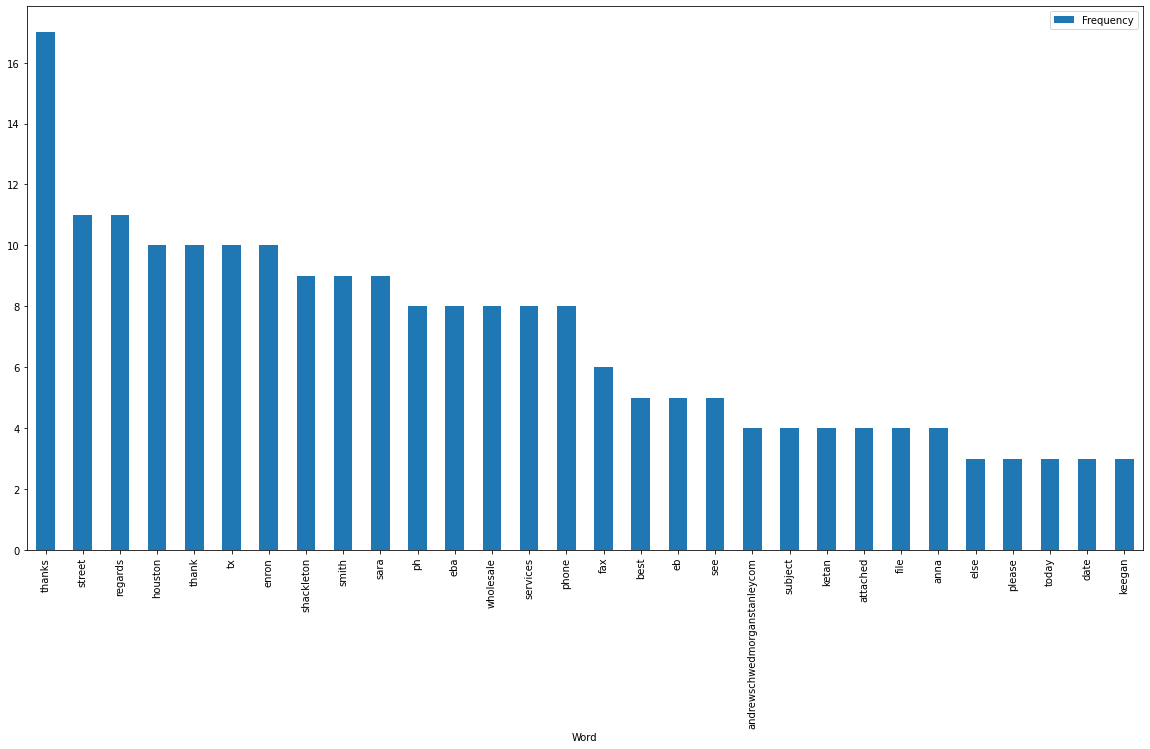

In [ ]:

word_data = []
#Sort dictionary by highest word frequency. 
for key, value in sorted(freq_words.items(), key=lambda item: item[1], reverse=True):
    word_data.append([key, freq_words[key]])

#Prepare to plot bar graph of top words. 
#Create dataframe with Word and Frequency, then sort in Descending order. 
freq_words_df = pd.DataFrame.from_dict(freq_words, orient='index').reset_index()
freq_words_df = freq_words_df.rename(columns={"index": "Word", 0: "Frequency"})
freq_words_df = freq_words_df.sort_values(by=['Frequency'],ascending = False)
freq_words_df.reset_index(drop = True, inplace=True)
freq_words_df.head(30).plot(x='Word', kind='bar', figsize=(20,10))

# extract_word_vectors

In [ ]:
! wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip glove*.zip

--2020-12-13 11:59:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-13 11:59:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-13 11:59:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
def extract_word_vectors():
    '''This returns word vectors from the pretrained glove model. '''
    word_embeddings = {}
    f = open('glove.6B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    return word_embeddings

# get_tokenized_sentences

In [ ]:
def get_tokenized_sentences(df):
    '''
    The tokenized sentences were done during preprocessing, 
    so this function retrieves them from the dataframe, then flattens the list. 
    '''
    if (type(df.extractive_sentences) != list):
        clean_sentences = df.tokenized_body.tolist()
    else:
        clean_sentences = df.tokenized_body
    #flatten list
    clean_sentences = [y for x in clean_sentences for y in x]
    return clean_sentences

# get_extractive_sentences

In [ ]:
def get_extractive_sentences(df):
    '''Retrieve original email sentences and index them. This will be used to generate the extracted summaries. '''
    if (type(df.extractive_sentences) != list):
        sentences_list = df.extractive_sentences.tolist()
    else:
        sentences_list = df.extractive_sentences
    # flatten list as tuples containting (sentence, dataframe index)  to reassociate summary with original email. 
    sentences = []
    for counter, sublist in enumerate(sentences_list):
        for item in sublist:
            sentences.append([counter, item])
        break
    return sentences

# create_sentence_vectors

In [ ]:
def create_sentence_vectors(clean_sentences, word_embeddings):
    '''Create sentence_vectors for each tokenized sentence using the word_embeddings model. '''
    sentence_vectors = []
    for i in clean_sentences:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            v = np.zeros((300,))
        sentence_vectors.append(v)
    return sentence_vectors

# rank_sentences

In [ ]:
def rank_sentences(sentences, sentence_vectors):
    '''This function takes in a list of sentences to input into TextRank. The resulting ranks are what the model 
    calculated as the most important sentences. '''
    sim_mat = np.zeros([len(sentences), len(sentences)])
    #Initialize matrix with cosine similarity scores. 
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                shape_len = len(sentence_vectors[i])
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,shape_len), sentence_vectors[j].reshape(1,shape_len))[0,0]
    nx_graph = nx.from_numpy_array(sim_mat)

    #Pair sentence with it's similarity score then sort.    
    try:
        scores = nx.pagerank(nx_graph)
        ranked_sentences = sorted(((scores[i],s[0],s[1]) for i,s in enumerate(sentences)), reverse=True)
        
    except:
        ranked_sentences = sorted(((0,s[0],s[1]) for i,s in enumerate(sentences)), reverse=True)

    return ranked_sentences

# summarize_emails

In [ ]:
def summarize_emails(word_embeddings, masked_df):
    '''Function to wrap up summarization process'''
    if len(masked_df) != 1:
        print("Total number of emails to summarize: " + str(len(masked_df)))

    sentences = get_extractive_sentences(masked_df)

    clean_sentences = get_tokenized_sentences(masked_df)
    #Generate sentence vectors
    sentence_vectors = create_sentence_vectors(clean_sentences, word_embeddings)
    #Create a list of ranked sentences. 
    ranked_sentences = rank_sentences(sentences, sentence_vectors)

    return ranked_sentences

# Ranked Sentences with their scores

In [ ]:

word_embeddings = extract_word_vectors()
row_len = len(cleaned_threads_df)
score = []
sentence = []
index = []
for i in range(row_len):
  df=pd.DataFrame(cleaned_threads_df.iloc[i]).T
  rank_tuple = summarize_emails(word_embeddings, df)
  for t in rank_tuple:
    index.append(i)
    score.append(t[0])
    sentence.append(t[2])


ranke_df = pd.DataFrame()
ranke_df['Index'] = pd.Series(index)
ranke_df['Sentence'] = pd.Series(sentence)
ranke_df['Score'] = pd.Series(score)
ranke_df



,Index,Sentence,Score
0,0,"thanks, Tanya and Debbie: Is Monica working on...",0.500000
1,0,Carol St. Clair EB 4539 7138533989 (phone) 713...,0.500000
2,1,Please check the package to make sure everythi...,0.107890
3,1,I would request you send the originals to me i...,0.104821
4,1,"As mentioned on the phone, a large portion of ...",0.098023
...,...,...,...
951,68,">>""Thankfully, I was saved.",0.008849
952,68,Kyle was >>valedictorian of our class.,0.006813
953,69,"Regards, It seems that tomorrow, Friday, does ...",0.371151
954,69,Does this fit your calendar as well?,0.333915
